In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import gsw as sw
import scipy.signal as signal

import numpy.ma as ma

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]

# def spherical(h, a, C0):
#     '''
#     Spherical model of the semivariogram
#     '''
#     # if h is a single digit
#     if type(h) == np.float64:
#         # calculate the spherical function
#         if h <= a:
#             return C0*(1.5*(h/a) - (1/3)*((h**3.0)/(a**3.0)))
#         else:
#             return C0
#     # if h is an iterable
#     else:
#         # calculate the spherical function for all elements
#         a = np.ones( h.size ) * a
#         C0 = np.ones( h.size ) * C0
#         return map(spherical, h, a, C0)
    
def cvmodel(P, model, hs, bw):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C(P, hs[0], bw)
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=param: C0 - model( h, a, C0 )
    return covfct

In [3]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv('../data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok3f = pd.read_csv('../data/filtered_O2Ar/Tokyo3_filt_vOct17.csv', sep = ',')
Tok3f['density'] = sw.rho(Tok3f['S'].values,Tok3f['T'].values,0)
Tok3f = Tok3f[(Tok3f['Lon']>minlon) & (Tok3f['Lon']<maxlon)]

Tok3 = pd.read_csv('../data/Tokyo3_vSept16.csv', sep=',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv('../data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [4]:
# pick which cruise to work on
datain = Tok1
var = 'Fluo'

# Tok1['x'] = sw.distance(Tok1['Lon'].values,Tok1['Lat'].values, 0)[0]

cdistance = sw.distance(datain['Lon'].values,datain['Lat'].values, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)

datain['x'] = ctrack

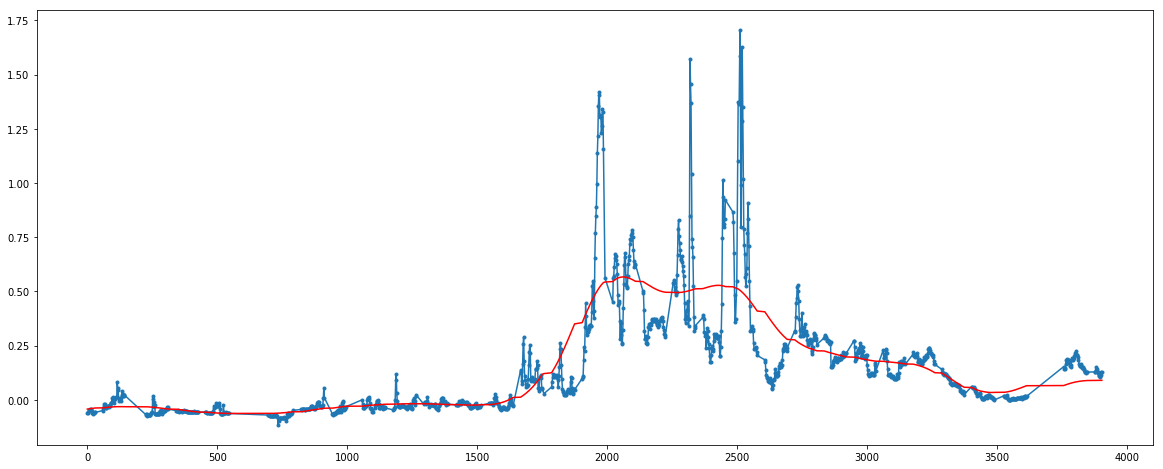

In [5]:
# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.01 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
dataf = signal.filtfilt(B,A, datain[var])

fig1 = plt.figure(2, figsize=(20,8))
plt.plot(datain['x']/1000, datain[var], '.-', datain['x']/1000, dataf,'r')
plt.show()

In [6]:
# do the semivariogram calculation

# organise the data in the right way for the functions
# divide the ctrack by 1000 to get units of km
res = datain[var]-dataf
P = np.transpose([datain['x']/1000, np.zeros(len(datain['x'])), res])

# bandwidth, plus or minus 0.5 km
bw = 2
# lags in 500 meter increments from zero to 200km
hs = np.arange(0,150,bw)
sv = SV( P, hs, bw )



In [7]:
def func(x, a, c0, cinf):

    if type(x) == np.float64:
        # calculate the spherical function
        if x <= a:
            return c0 + (cinf - c0)*(1.5*(x/a) - 0.5*((x**3.0)/(a**3.0)))
        else:
            return cinf
    # if h is an iterable
    else:
        # calculate the spherical function for all elements
        a = np.ones( x.size ) * a
        c0 = np.ones( x.size ) * c0
        cinf = np.ones( x.size ) * cinf
        return map(func, x, a, c0, cinf)

x0 = np.zeros(len(sv))

p0 = [30, np.min(sv[1]), np.max(sv[1])]
import scipy.optimize as optimization

popt, pcov =  optimization.curve_fit(func, sv[0], sv[1],p0, sigma=None)

nugget = 0.004699, range = 112.143688 km, sill = 0.037588


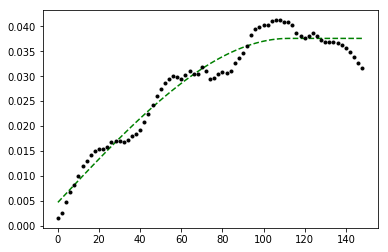

In [8]:
# plt.axis([0, 150, 0, 25])

a = popt[0]
c0 = popt[1]
cinf = popt[2]

y = func(sv[0], *popt)
# y[sv[0] > a] = cinf

plt.plot(sv[0],y, 'g--')
# plt.axvline(a)
# plt.axhline(cinf)
plt.plot(sv[0], sv[1], '.k')

print 'nugget = %2f, range = %2f km, sill = %2f' % (popt[1], popt[0], popt[2])

In [9]:
print '%5f' % popt[0]

112.143688


In [10]:
pcov


array([[1.71115801e+01, 1.67780940e-03, 1.29742198e-03],
       [1.67780940e-03, 6.01335627e-07, 5.25203004e-08],
       [1.29742198e-03, 5.25203004e-08, 2.29638353e-07]])